# Neural Network and Analytic Solution Comparison

We compute numerical solutions to the 1-dimensional heat equation using a neural network. We compare the numerical solutions with the analytic solution.

In [1]:
from util_funcs import analytic_sol
from HeatEqNN import HeatEqNN

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import mean_squared_error as mse
import seaborn as sns
import keras

from plotting import set_plot_params

2025-12-18 15:33:04.806088: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-18 15:33:04.857709: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-18 15:33:05.914005: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


We will compare solutions for $t = 0.2$ and $t = 1$.


### Anlalytical solution
The analytical solution is given by
$$ e^{-\pi^2t}\sin(\pi x) $$

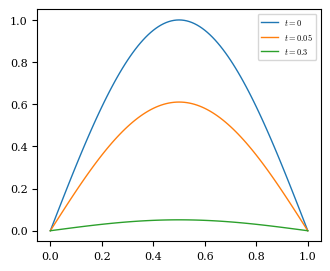

In [2]:
set_plot_params()

x10 = np.linspace(0, 1, 11)
x100 = np.linspace(0,1,101)

ts_plot = [0, 0.05, 0.3]

x100_grid, t_grid = np.meshgrid(x100, ts_plot)
x10_grid, t_grid10 = np.meshgrid(x10, ts_plot)

points = np.vstack([x100, t_grid[0]])
a_sol_init = analytic_sol(points)


points = np.vstack([x100, t_grid[1]])
a_sol_t1 = analytic_sol(points)

points = np.vstack([x100, t_grid[2]])
a_sol_t2 = analytic_sol(points)


points = np.vstack([x10, t_grid10[1]])
a_sol10_t1 = analytic_sol(points)

points = np.vstack([x10, t_grid10[2]])
a_sol10_t2 = analytic_sol(points)


plt.plot(x100, a_sol_init, label = r"$t=0$")

plt.plot(x100, a_sol_t1, label = r"$t=0.05$")

plt.plot(x100, a_sol_t2, label = r"$t=0.3$")

plt.legend()
plt.show()

### Neural Network:
We will train on $100$ randomly generated points $(x,t)$, with $x\in [0,1)$ and $t\in [0,0.3)$. The points are uniformly sampled.

In [4]:
num_points = 100

np.random.seed(2025)

rng = np.random.default_rng()
xs = rng.random((num_points))*1
ts = rng.random((num_points))*0.3

training_points = np.vstack([xs, ts]).T

#### Grid Search: Activation Function and Number of Hidden Layers

In [5]:
keras.utils.set_random_seed(2025)
its = 1

layer_size = 40

t2s = np.ones_like(x100)*ts_plot[2]
pred_points = np.vstack([x100, t2s])

act_func = ["sigmoid","tanh", "relu", "silu"]
num_hidden_layers = [1,2,3,4]

MSE_mat_af_hl = np.zeros((len(act_func),len(num_hidden_layers)))
for it in range(its):
    for i, func in enumerate(act_func):
        for j, num in enumerate(num_hidden_layers):
            NN = HeatEqNN(num, layer_size, func)
            NN.train(training_points, epochs=1000)
            pred = NN.predict(pred_points.T)
            MSE_mat_af_hl[i,j] += mse(a_sol_t2, pred)
            del NN
MSE_mat_af_hl /= its

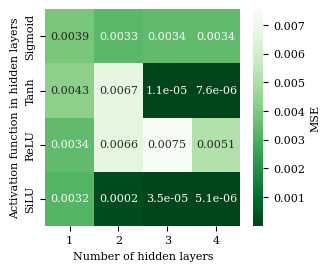

In [6]:
set_plot_params()

activation_labels = ["Sigmoid", "Tanh", "ReLU", "SiLU"]

sns.heatmap(MSE_mat_af_hl, annot=True, cmap="Greens_r",
            yticklabels=activation_labels, xticklabels=num_hidden_layers, cbar_kws={"label": "MSE"}, fmt=".2g"
            )
plt.xlabel("Number of hidden layers")
plt.ylabel("Activation function in hidden layers")
#plt.title(r"$t=0.30$")
plt.savefig("../fig/af_vs_hl_gridsearch.pdf", bbox_inches="tight")
plt.show()
plt.close()

#### Grid Search: Nodes Per Layer and Number of Hidden Layers

In [7]:
keras.utils.set_random_seed(2025)
its = 1

func = "silu"

layer_size = [20,40, 60, 80]
num_hidden_layers = [1,2,3,4]

MSE_mat_nodes_hl = np.zeros((len(layer_size),len(num_hidden_layers)))
for it in range(its):
    for i, size in enumerate(layer_size):
        for j, num in enumerate(num_hidden_layers):
            NN = HeatEqNN(num, size, func)
            NN.train(training_points, epochs=1000)
            t2s = np.ones_like(x100)*ts_plot[2]
            pred_points = np.vstack([x100, t2s])
            pred = NN.predict(pred_points.T)
            MSE_mat_nodes_hl[i,j] += mse(a_sol_t2, pred)
MSE_mat_nodes_hl /= its

[[2.82927965e-03 9.33580009e-04 2.11283850e-04 1.34559149e-05]
 [3.46244419e-03 2.67118541e-04 2.63400367e-05 3.43302847e-06]
 [3.28812693e-03 1.85695990e-04 2.29616108e-05 2.44028686e-07]
 [2.75272846e-03 1.73592779e-04 4.84753290e-06 3.01107255e-06]]


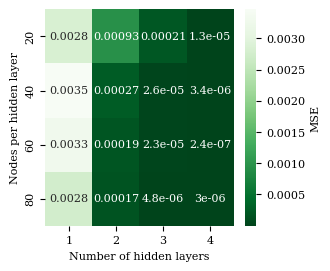

In [8]:
set_plot_params()

print(MSE_mat_nodes_hl)

sns.heatmap(MSE_mat_nodes_hl, annot=True, cmap="Greens_r",
            yticklabels=layer_size, xticklabels=num_hidden_layers, cbar_kws={"label": "MSE"}, fmt=".2g"
            )

plt.xlabel("Number of hidden layers")
plt.ylabel("Nodes per hidden layer")
#plt.title(r"$t=0.30$")
plt.savefig("../fig/nodes_vs_nhl_grid_search.pdf", bbox_inches="tight")
plt.show()
plt.close()

#### Grid Search: Learning Rate and Regularization Parameter

In [17]:
keras.utils.set_random_seed(2025)
its = 1

func = "silu"
layers = 4
size = 60

reg_param = [1, 1/10, 1/100, 1/1000, 0]
learning_rate = [0.1, 0.01, 0.001, 0.0001]

MSE_mat_lr_reg = np.zeros((len(reg_param),len(learning_rate)))
for it in range(its):
    for i, lam in enumerate(reg_param):
        for j, lr in enumerate(learning_rate):
            NN = HeatEqNN(layers, size, func, learning_rate = lr,
                          regularizer="L2", reg_param=lam)
            NN.train(training_points)
            t2s = np.ones_like(x100)*ts_plot[2]
            pred_points = np.vstack([x100, t2s])
            pred = NN.predict(pred_points.T)
            MSE_mat_lr_reg[i,j] += mse(a_sol_t2, pred)
MSE_mat_lr_reg /= its



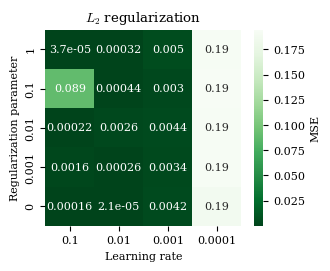

In [18]:
set_plot_params()

sns.heatmap(MSE_mat_lr_reg, annot=True, cmap="Greens_r",
            yticklabels=reg_param, xticklabels=learning_rate, cbar_kws={"label": "MSE"}, fmt=".2g"
            )

plt.xlabel("Learning rate")
plt.ylabel("Regularization parameter")
plt.title(r"$L_2$ regularization")
plt.savefig("../fig/L2reg_vs_lr_grid_search.pdf", bbox_inches="tight")
plt.show()
plt.close()

In [14]:
keras.utils.set_random_seed(2025)
its = 1

func = "silu"
layers = 4
size = 60

reg_param = [1, 1/10, 1/100, 1/1000, 0]
learning_rate = [0.1, 0.01, 0.001, 0.0001]

MSE_mat_lr_1reg = np.zeros((len(reg_param),len(learning_rate)))
for it in range(its):
    for i, lam in enumerate(reg_param):
        for j, lr in enumerate(learning_rate):
            NN = HeatEqNN(layers, size, func, learning_rate = lr,
                          regularizer="L1", reg_param=lam)
            NN.train(training_points)
            t2s = np.ones_like(x100)*ts_plot[2]
            pred_points = np.vstack([x100, t2s])
            pred = NN.predict(pred_points.T)
            MSE_mat_lr_1reg[i,j] += mse(a_sol_t2, pred)
MSE_mat_lr_1reg /= its

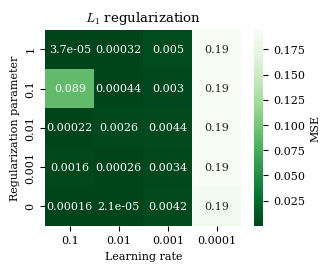

In [15]:
set_plot_params()

sns.heatmap(MSE_mat_lr_1reg, annot=True, cmap="Greens_r",
            yticklabels=reg_param, xticklabels=learning_rate, cbar_kws={"label": "MSE"},fmt=".2g"
            )

plt.xlabel("Learning rate")
plt.ylabel("Regularization parameter")
plt.title(r"$L_1$ regularization")
plt.savefig("../fig/L1reg_vs_lr_grid_search.pdf", bbox_inches="tight")
plt.show()
plt.close()

##### "Best" combination:
SiLU,\
60 nodes with 4 hidden layers,\
L1 = L2 reg, $\lambda = 0$, no reg,\
Learning rate = 0.01


Model: "functional_559"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_559 (InputLayer)    │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2235 (Dense)              │ (None, 20)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2236 (Dense)              │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2237 (Dense)              │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2238 (Dense)              │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2239 (Dense)              │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,341 (10.48 KB)

 Trainable params: 1,341 (10.48 KB)

 Non-trainable params: 0 (0.00 B)